In [1]:
import sys

sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_segmentation")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/simpler_models")


from train_fn import list_directory_tree_with_pathlib

In [2]:
import torch
# from EmetMamba_alpha import EmetMamba as model_alpha
# from EmetMamba_segmentation import EmetMamba as model_segmentation
# from EmetMamba import EmetMamba as model_K
# from EmetMamba_seg_and_regr import EmetMamba as model_seg_reg

In [3]:
# model_alpha = torch.load(
#     "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha/model_alpha_2_0p1_1e-4_8_8kexps"


In [4]:
from mamba_ssm import Mamba
from einops import rearrange
import torch.nn as nn

/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class segmentation_model(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.lstm = nn.LSTM(
            input_size = d_model,
            hidden_size=d_state,
            num_layers = expand,
            bidirectional=True,
            batch_first=True,
            ).to(device)

        self.dense = nn.Linear(d_state * 2, 3).to(device)
        self.dropout = nn.Dropout(p=dropout).to(device)

    def forward(self, x):
        

        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        dense_out = self.dense(lstm_out)
        
        return dense_out  # No activation here ! It is done by the cross entropy loss


class K_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model*2, out_features=2).to(device)

        self.softplus = nn.Softplus()

    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])

        mamba_out = torch.cat((forward_mamba, backward_mamba), dim = -1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        out = torch.clamp(out, min=0, max=1e12)
        out[out < 1e-7] = 0
        return out


class alpha_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model*2, out_features=2).to(device)

        # self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])

        mamba_out = torch.cat((forward_mamba, backward_mamba), dim=-1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")
        mamba_out = self.dropout(mamba_out)
        
        out = self.fc(mamba_out)
        out = self.relu(out)
        out = torch.clamp(out, min=0, max = 2)
        
        return out

In [9]:
class all_at_the_same_time(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.model_K = K_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        self.model_alpha = alpha_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        # self.segmentation = segmentation_model(
        #     d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        # )
        self.segmentation = torch.load("300_epoch_lstm_10kfiles_classification_only")

    def forward(self, x):
        probas = self.segmentation(x)

        classes = torch.argmax(torch.softmax(probas, dim=2), dim=2)

        classes[x[:, :, 0] == 0] = 0

        classes[x[:, :, 0] == 0] = 0
        classes = classes.unsqueeze(-1)  # adding a dimension for the next step
        concat_entry = torch.cat((classes, x[:,:,:]), dim=2)

        alpha = self.model_alpha(concat_entry)

        K = self.model_K(concat_entry)

        return probas, alpha, K

In [10]:
model_seg_reg = torch.load("../LSTM/60epoch_10kfiles_3atsametime_lstmxmamba")

In [11]:
# model_alpha.eval()
# model_segmentation.eval()
# model_K.eval()
model_seg_reg.eval()

all_at_the_same_time(
  (model_K): K_regression(
    (mamba): Mamba(
      (in_proj): Linear(in_features=7, out_features=56, bias=False)
      (conv1d): Conv1d(28, 28, kernel_size=(4,), stride=(1,), padding=(3,), groups=28)
      (act): SiLU()
      (x_proj): Linear(in_features=28, out_features=257, bias=False)
      (dt_proj): Linear(in_features=1, out_features=28, bias=True)
      (out_proj): Linear(in_features=28, out_features=7, bias=False)
    )
    (flipped_mamba): Mamba(
      (in_proj): Linear(in_features=7, out_features=56, bias=False)
      (conv1d): Conv1d(28, 28, kernel_size=(4,), stride=(1,), padding=(3,), groups=28)
      (act): SiLU()
      (x_proj): Linear(in_features=28, out_features=257, bias=False)
      (dt_proj): Linear(in_features=1, out_features=28, bias=True)
      (out_proj): Linear(in_features=28, out_features=7, bias=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc): Linear(in_features=2786, out_features=2, bias=True)
    (softplus): Softplus

In [12]:
data_path = "track_2/"
directory_files = list_directory_tree_with_pathlib(data_path)

In [13]:

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return (ang1 - ang2) % (2 * np.pi)

In [14]:
import pandas as pd
import numpy as np


def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max -1, 6)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()  
        data[:, 0] = data[:, 0] - data[0, 0] + 1  # putting first frame rate to 1
        data[:, 1] = data[:, 1] - data[0, 1]  # putting initial position to 0
        data[:, 2] = (
            data[:, 2] - data[0, 2]
        )  # putting initital position to 0        # print(exp["frame"])
        # Displacement
        Dx = data[1:,1] - data[:-1,1]
        Dy = data[1:,2] - data[:-1,2]

        Dx2 = data[2:,1] - data[:-2,1]
        Dy2 = data[2:,1] - data[:-2,1]

        dist_1 = np.sqrt(Dx**2 + Dy**2)
        dist_2 = np.sqrt(Dx2**2 + Dy2**2)
        
        
        MDx = np.zeros(len(Dx))
        MDy = np.zeros(len(Dx))
        MSD = np.zeros(len(Dx))
        mean_dist_1 = np.zeros(len(Dx))
        mean_dist_2 = np.zeros(len(Dx))
        
        angles = np.zeros(len(Dx))
        distance_displacement = np.sqrt(np.power(Dx,2) + np.power(Dy,2))
        #Displacement average

        for i in range(1, len(Dx)+1):
            # MDx[i-1] = np.mean(data[i:,1] - data[:-i,1])
            # MDy[i-1] = np.mean(data[i:,2] - data[:-i,2])
            MSD[i-1] = np.mean((data[i:,2] - data[:-i,2])**2)
            A = (data[(i-1),1], data[(i-1),2])
            B = (data[i,1], data[i,2])
        
            # Computation of angles

            angles[i-1] = angle_between(A,B)

            start= i - 1
            start = max(start, 0)
            end_1 = i + 1 
            end_2 = i + 1
            if end_1 > len(Dx):
                end_1 = len(Dx)
            if end_2 >len(Dx) - 1:
                end_2 = len(Dx) - 1

            if end_1 != start:
                mean_dist_1[i-1] = np.mean(dist_1[start:end_1+1])
            if end_2 != start:
                mean_dist_2[i-1] = np.mean(dist_2[start:end_2+1])
        
            # print(np.mean(dist_1[start:end_1+1]))
            # print(np.mean(dist_2[start:end_2+1]))

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            # final_data[n, :, :] = data[:T_max, :]
            final_data[n,:,0] = Dx[:(T_max-1)]
            final_data[n,:,1] = Dy[:(T_max-1)]
            final_data[n,:,2] = mean_dist_1[:(T_max-1)]
            final_data[n,:,3] = mean_dist_2[:(T_max-1)]
            final_data[n,:,4] = distance_displacement[:(T_max-1)]
            final_data[n,:,5] = angles[:(T_max-1)]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, : (data.shape[0] -1), 0] = Dx
            final_data[n, : (data.shape[0] -1), 1] = Dy
            final_data[n, : (data.shape[0] -1), 2] = mean_dist_1
            final_data[n, : (data.shape[0] -1), 3] = mean_dist_2
            final_data[n, : (data.shape[0] -1), 4] = distance_displacement
            final_data[n, : (data.shape[0] -1), 5] = angles

    # Return the padded data and labels
    return final_data

In [16]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    # dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)
    df_padded = df_padded[:, :, :]
    # if nb_trajs % 20 == 0:

    #     for i in range(dataset.shape[0]):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    # else :
    #     for i in range(dataset.shape[0] - 1):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #     #On place i dans la dernière couche
    #     i+=1
    #     remaining_trajs = nb_trajs % 20
    #     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    #     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(df_padded.astype(np.float32))

In [19]:
read_dataset(directory_files[0])

tensor([[[ -2.5876,   2.0039,   3.7929,   2.3270,   3.2728,   3.8006],
         [  0.7758,  -5.2131,   3.4113,   5.7581,   5.2706,   4.5674],
         [ -2.7750,   0.5818,   4.1706,   5.1465,   2.8353,   0.5367],
         ...,
         [  0.8020,   2.6960,   5.8884,   2.0302,   2.8128,   0.0660],
         [ -0.8208, -11.1629,   7.4262,   4.0337,  11.1931,   6.0159],
         [ -2.0314,   3.0436,   3.6592,   0.0000,   3.6592,   0.0816]],

        [[  2.1948,  -3.0248,   5.1782,   3.9567,   3.7372,   0.9431],
         [ -0.2914,   8.1143,   4.4459,   4.7786,   8.1196,   4.1272],
         [ -2.5091,   2.6892,   3.6081,   4.6378,   3.6780,   5.8476],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

        [[ -9.0866,  -3.8449,   6.2737,  10.0185,   9.8666,   2.7413],
         [  2.3045,  -0.3565,   4.6219,  10.6

In [20]:
results_alpha = {}
results_K = {}
results_segmentation = {}

with torch.no_grad():
    for file in directory_files:
        data = read_dataset(file)
        data = data.to("cuda")
        # results_alpha[file] = model_alpha(data).squeeze()
        # results_K[file] = model_K(data).squeeze()
        # results_segmentation[file] = torch.argmax(
        #     model_segmentation(data[:, :, 1:]).squeeze(), dim=-1
        # )

        segmentation, alpha, K = model_seg_reg(data)
        results_alpha[file] = alpha.squeeze()
        results_K[file] = K.squeeze()
        results_segmentation[file] = torch.argmax(segmentation.squeeze(), dim=-1)

        # data

In [21]:
keys = list(results_alpha.keys())

In [22]:
import matplotlib.pyplot as plt

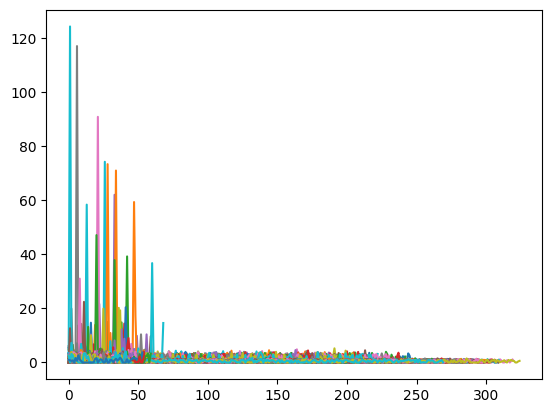

In [23]:
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 0])

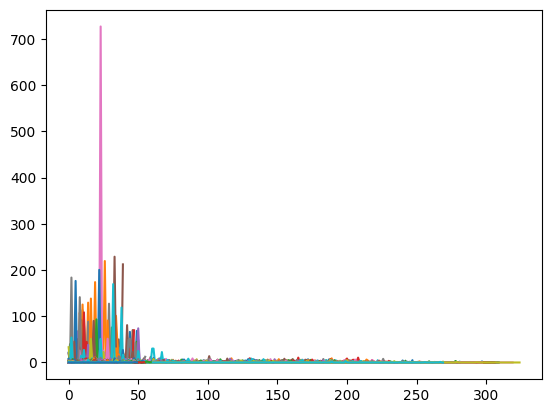

In [24]:
j = 0
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 1])
    j += len(K[:, 1])

In [25]:
results_alpha

{PosixPath('track_2/exp_10/trajs_fov_29.csv'): tensor([[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.5836, 0.9488],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2593, 0.1593],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [1.0797, 1.0073],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.6037],
         [2.0000, 2.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [2.0000, 2.0000],
         [0.0000, 0.0000],
         [1.2595, 1.6582],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.1354, 0.0000],
         [2.0000, 2.0000],
         

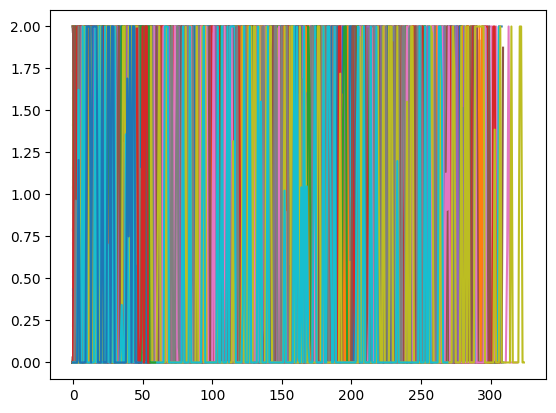

In [26]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 0])

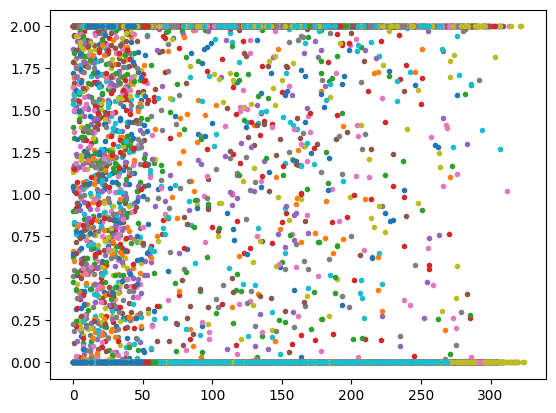

In [27]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 1], ".")

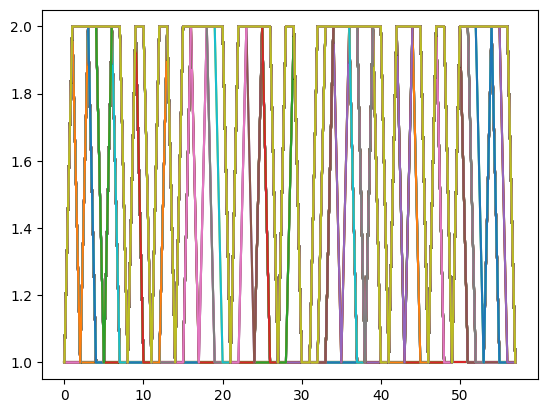

In [28]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    # segmentation[segmentation==0] = 1
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

In [29]:
## As a post-treatment task, we need to remove the segments which size are smaller than 3 as not possible

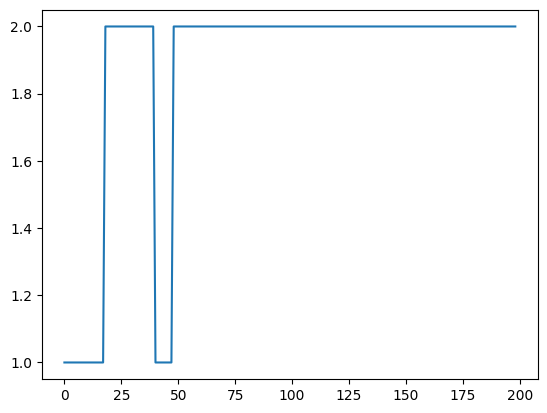

In [36]:
plt.plot(results_segmentation[keys[-4]][19,:].to("cpu"))

In [37]:
def change_small_sections(arr):
    # Find the start and end indices of sections
    diff = np.diff(arr)
    section_starts = np.where(diff != 0)[0] + 1
    section_starts = np.concatenate(([0], section_starts))
    section_ends = np.concatenate((section_starts[1:], [len(arr)]))
    # Iterate through sections
    for start, end in zip(section_starts, section_ends):
        section_length = end - start
        if section_length < 3:

            arr[start:end] =  3 - arr[start:end] 

    return arr

for i in keys:
        for j in range(results_segmentation[i].size(0)):
            
            results_segmentation[i][j,:] = change_small_sections(results_segmentation[i][j,:].to("cpu"))
                


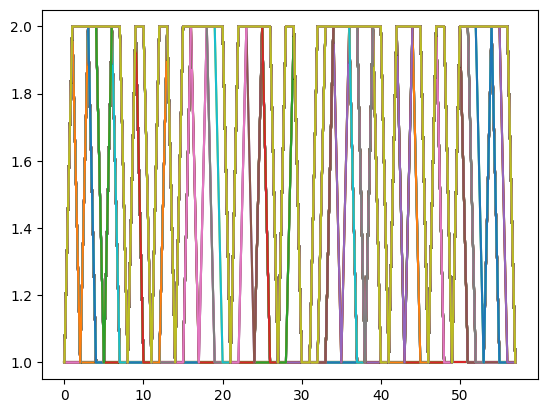

In [38]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    # segmentation[segmentation==0] = 1
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

In [39]:
## Remove all the samm sections



In [40]:
def generate_solution(file):
    
    df = pd.read_csv(file)

    total_sol = ""
    for id, group in df.groupby("traj_idx"):
        sol=""

        states = results_segmentation[file][int(id)].to("cpu") - 1
        alphas = results_alpha[file][int(id)].to("cpu")
        Ds = results_K[file][int(id)].to("cpu")
        unique_states = np.unique(states)
        
        if len(unique_states) == 1:
            
            if alphas[0] < 0.01:
                state = 1
            elif alphas[0] > 1.8:
                state = 3
            else:
                state = 2

            total_sol+= f"{int(id)},{Ds[0]},{alphas[0]},{state},{len(group["x"])}\n"
        else:

            state = [0,0]
            if alphas[0] < 0.001:
                state[0] = 1
            elif alphas[0] > 1.8:
                state[0] = 3
            else:
                state[0] = 2

            if alphas[1] < 0.001:
                state[1] = 1
            elif alphas[1] > 1.8:
                state[1] = 3
            else:
                state[1] = 2

            if Ds[0] < 1e-7:
                Ds[0] = 0
            if Ds[1] < 1e-7:
                Ds[1] = 0


            init_state = int(states[0])
            sol = f"{int(id)},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"

            for i in range(len(group["frame"]) -1):
                if int(states[i]) != init_state:
                    init_state = (init_state + 1) % 2
                    sol += f"{int(group["frame"].iloc[i])},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"
            sol+=f"{len(group["x"])}\n"
            total_sol+=sol

    return total_sol

In [42]:
dict_solutions = {}
j=0
for i in keys:
    j=0
    dict_solutions[i] = generate_solution(i)

In [43]:
keys = list(dict_solutions.keys())

In [44]:
print(generate_solution(keys[5]))

0,0.0,2.0,3,54
1,0.0,0.0,1,56
2,0.0,0.0,1,136
3,0.0,0.0,1,96
4,0.0,2.0,3,21
5,0.0,0.0,1,41
6,0.0,0.0,1,108,0.0,0.0,1,33
7,0.0,1.0962661504745483,2,34
8,0.0,0.0,1,47
9,14.267678260803223,0.0,1,200
10,0.0,2.0,3,54
11,0.0,0.0,1,161
12,3.7662734985351562,0.0,1,200
13,1.9077932834625244,0.0,1,200
14,0.0,0.0,1,27
15,0.0,0.0,1,67
16,0.0,0.0,1,156,0.0,0.4053298532962799,2,45
17,0.0,0.0,1,75
18,0.0,0.0,1,200
19,0.0,1.3320969343185425,2,24
20,0.0,0.0,1,69
21,0.0,2.0,3,37
22,0.0,0.0,1,92
23,0.0,0.0,1,65
24,0.0,0.8691786527633667,2,32
25,0.5147420167922974,0.0,1,200
26,0.0,0.0,1,84
27,0.0,2.0,3,22
28,0.0,0.0,1,29
29,0.0,2.0,3,27
30,0.0,1.0139354467391968,2,48
31,0.0,0.0,1,30
32,0.0,2.0,3,39
33,0.0,0.0,1,22
34,0.0,0.0,1,74
35,0.0,0.0,1,74
36,0.0,0.0,1,24
37,0.0,0.0,1,60
38,0.0,0.0,1,69
39,3.3465747833251953,0.0,1,179,7.205461502075195,0.0,1,182
40,0.0,0.0,1,45
41,4.568264007568359,0.0,1,200
42,0.0,0.0,1,43
43,0.0,0.0,1,21
44,0.0,0.0,1,33
45,1.8042789697647095,0.0,1,200
46,0.0,0.0,1,200
47,0.0,0.0,1

In [45]:
from copy import copy
from pathlib import Path

In [46]:
for i in keys:
    key = copy(i)
    file_name = i.parts[-1][6:-4] + ".txt"
    total_path = Path(*["solution", *i.parts[-3:-1],file_name])
    folder_path = Path(*total_path.parts[:-1])
    folder_path.mkdir(parents=True, exist_ok=True)

    with open(total_path, "w") as file:
        file.write(dict_solutions[key])


In [47]:
total_path

PosixPath('solution/exp_5/.ipynb_checkpoints/fov_1-checkpoint.txt')

In [48]:
dict_solutions[keys[0]]

'0,5.400410175323486,0.0,1,200\n1,0.0,0.0,1,37\n2,0.0,0.0,1,113\n3,0.0,0.5835955142974854,2,22\n4,0.0,0.0,1,142\n5,1.7591434717178345,0.0,1,173\n6,0.0,0.2592931091785431,2,24\n7,1.3252339363098145,0.0,1,129\n8,3.7905139923095703,0.0,1,200\n9,0.0,0.0,1,22\n10,0.0,0.0,1,175\n11,0.0,0.0,1,200\n12,0.0,0.0,1,102\n13,0.0,0.0,1,58\n14,4.0330047607421875,0.0,1,200\n15,0.0,0.0,1,98\n16,0.0,0.0,1,21\n17,0.0,0.0,1,27\n18,0.0,1.079727292060852,2,25\n19,0.0,0.0,1,28\n20,0.0,0.0,1,31\n21,3.2028136253356934,0.0,1,200\n22,0.0,2.0,3,57\n23,0.0,0.0,1,55\n24,0.0,0.0,1,57\n25,0.0,0.0,1,33\n26,0.0,2.0,3,64\n27,4.624131202697754,0.0,1,200\n28,0.0,1.2594584226608276,2,43\n29,0.0,0.0,1,36\n30,2.9874367713928223,0.0,1,200\n31,3.696542739868164,0.0,1,200\n32,0.0,0.0,1,119\n33,0.0,0.13536229729652405,2,86\n34,0.0,2.0,3,20\n35,0.0,2.0,3,26\n36,9.442585945129395,0.0,1,21\n37,0.0,2.0,3,70\n38,0.36087876558303833,0.0,1,149\n39,0.0,0.05083882808685303,2,26\n40,0.0,0.0,1,99\n41,2.275156021118164,0.0,1,200\n42,0.0,0.0,

In [52]:
generate_solution(key)

'0,0.23165014386177063,1.2371118068695068,2,20,0.24282240867614746,1.2909269332885742,2,21,0.23165014386177063,1.2371118068695068,2,200\n1,0.34733814001083374,1.0400372743606567,2,142\n2,0.15508884191513062,1.0107189416885376,2,200\n3,0.210367813706398,1.1001538038253784,2,200\n4,0.4698292016983032,1.1957811117172241,2,19,0.38831090927124023,1.1956816911697388,2,22\n5,0.4073563814163208,0.6878052949905396,2,13,0.43899762630462646,0.7838762402534485,2,45,0.4073563814163208,0.6878052949905396,2,65,0.43899762630462646,0.7838762402534485,2,66,0.4073563814163208,0.6878052949905396,2,119,0.43899762630462646,0.7838762402534485,2,120,0.4073563814163208,0.6878052949905396,2,121,0.43899762630462646,0.7838762402534485,2,122,0.4073563814163208,0.6878052949905396,2,123,0.43899762630462646,0.7838762402534485,2,129,0.4073563814163208,0.6878052949905396,2,200\n6,0.16982266306877136,1.0123838186264038,2,200\n7,0.47865164279937744,0.686553418636322,2,18,0.6253977417945862,0.743803083896637,2,23,0.478651

In [ ]:
pd.read_csv(key)

,traj_idx,frame,x,y
0,0.0,0.0,161.164267,142.763482
1,0.0,1.0,161.077403,142.589036
2,0.0,2.0,161.354558,143.874786
3,0.0,3.0,161.169485,143.458609
4,0.0,4.0,159.270483,143.829008
...,...,...,...,...
6544,49.0,195.0,98.579725,116.656936
6545,49.0,196.0,98.723755,116.624656
6546,49.0,197.0,95.746428,116.273580
6547,49.0,198.0,95.677146,116.151651
